In [1]:
import pm4py
import pandas as pd
import numpy as np

# pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
log = pd.read_csv("ircc_uOttawa-filter_evt_10p.csv")
log

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_65567/705483942.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("ircc_uOttawa-filter_evt_10p.csv")


,Unnamed: 0,case_id,timestamp,act_upd_by,activity_id,group,cor,event,new_time
0,0,1,2024-06-03 00:00:00.000,CLIENT,0,NaN,Vietnam,Misrepresentation - NIL,1717372800
1,1,1,2024-06-03 00:00:00.000,CLIENT,0,NaN,Vietnam,Eligibility Assessment - NIL,1717372800
2,2,1,2024-06-03 00:00:00.000,CLIENT,0,NaN,Vietnam,Final Assessment - NIL,1717372800
3,3,1,2024-06-03 00:00:00.000,CLIENT,0,NaN,Vietnam,Received - Date,1717372800
4,4,1,2024-06-03 09:20:37.327,EAIMEL,1-SQ1RI5F,NaN,Vietnam,Application Status - Prospective,1717406437
...,...,...,...,...,...,...,...,...,...
525661,543278,7734,2024-06-17 07:46:39.433,SS36358,1-STC2A6X,NaN,Belgium,Other Reqs Assessment - NIL,1718610399
525662,543279,7734,2024-06-26 08:11:25.043,SS36358,1-STC2A6X,NaN,Belgium,Eligibility Assessment - Review Required,1719389485
525663,543280,7734,2024-06-28 10:45:09.050,SS36358,1-STC2A6X,NaN,Belgium,Eligibility Assessment - Failed,1719571509
525664,543281,7734,2024-06-28 10:45:09.587,SS36358,1-STC2A6X,NaN,Belgium,Final Assessment - Refused,1719571509


In [3]:
event_parts = log['event'].apply(lambda e: e.split(" - ")).to_list()
event_parts = pd.DataFrame(event_parts)

In [4]:
# event names with more than 2 parts (difficult ones)
troublemakers = event_parts[pd.notna(event_parts[2])][0].unique()
troublemakers

array(['Biometrics', 'Biographic', 'Biometric', 'Criminality',
       'Criminality Assessment'], dtype=object)

In [5]:
# have a closer look at the troublemakers
# for troublemaker in troublemakers:
#     print(event_parts[event_parts[0]==troublemaker].drop_duplicates())

In [6]:
# easy ones!
activ_lifec = event_parts[~ event_parts[0].isin(troublemakers)]

# start from these
activ_lifec = pd.DataFrame({ 'activity': activ_lifec[0], 'lifecycle': activ_lifec[1] })
# activ_lifec

In [7]:
# add activity_cols values to activity; add lifecycle_cols values to lifecycle
def create_activity_lifecycle(activity_label, activity_cols, lifecycle_cols, event_parts):
    def join_labels(row, cols):
        label = ""
        for col in cols:
             label +=  ((" - " if label != "" else "") + row[col] if pd.notna(row[col]) else "")
        return label
    
    subset = event_parts[event_parts[0]==activity_label]
    activity = subset.apply(lambda row: join_labels(row, activity_cols), axis=1)
    lifecycle = subset.apply(lambda row: join_labels(row, lifecycle_cols), axis=1)
    
    return pd.DataFrame({ 'activity': activity, 'lifecycle': lifecycle})

In [8]:
# for biographics,
# add first two parts to "activity"; add last two parts to "lifecycle"
biometrics_new = create_activity_lifecycle('Biometrics', [0, 1], [2, 3], event_parts)
activ_lifec = pd.concat([activ_lifec, biometrics_new])

# biometrics_new

In [9]:
# for biographic,
# add first part to "activity"; add last three parts to "lifecycle"
biographic_new = create_activity_lifecycle('Biographic', [0], [1, 2, 3], event_parts)
activ_lifec = pd.concat([activ_lifec, biographic_new])

# biographic_new

In [10]:
# for biometric,
# add first three parts to "activity"; add last two parts to "lifecycle"
biometric_new = create_activity_lifecycle('Biometric', [0, 1, 2], [3, 4], event_parts)
activ_lifec = pd.concat([activ_lifec, biometric_new])

# biometric_new

In [11]:
# for the others, 
for idx in range(3, len(troublemakers)):
    troublemaker = troublemakers[idx]
    
    # add first part to "activity"; add last three parts to "lifecycle"
    activity_new = create_activity_lifecycle(troublemaker, [0], [1, 2, 3], event_parts)
    activ_lifec = pd.concat([activ_lifec, activity_new])
    
    # print(activity_new.shape[0])

In [12]:
# drop all 'NIL' lifecycle events
activ_lifec = activ_lifec[activ_lifec['lifecycle']!='NIL']

In [13]:
# have a quick look
activ_lifec

,activity,lifecycle
3,Received,Date
4,Application Status,Prospective
5,Biometric Assessment,Required
11,Biometrics Fee,Outstanding
12,Study Permit Fee,Outstanding
...,...,...
525542,Criminality Assessment,Not Started
525544,Criminality Assessment,In Progress
525607,Criminality Assessment,Not Started
525609,Criminality Assessment,In Progress


In [14]:
# number of unique activities
len(activ_lifec['activity'].unique())

26

In [15]:
# join the "activity" & "lifecycle" to original log
ext_log = log.join(activ_lifec, how='inner') # merge on shared index

# do some checks
# activ_lifec should be same size as original log (not if we filtered activ_lifec)
# print(activ_lifec.shape[0] == log.shape[0])
# join result should have same size as activ_lifec
print(activ_lifec.shape[0] == ext_log.shape[0])
# event should always start with "activity"
check1 = ext_log.apply(lambda row: row['event'].startswith(row['activity']), axis=1)
print(ext_log[~ check1].shape[0]==0)
# event should always include "lifecycle"
check2 = ext_log.apply(lambda row: row['lifecycle'] in row['event'], axis=1)
print(ext_log[~ check2].shape[0]==0)

# prepare for pm
ext_log = ext_log[['case_id', 'timestamp', 'activity', 'lifecycle']]
ext_log = ext_log.rename(columns={ 'case_id': 'case:concept:name', 'lifecycle': 'concept:name', 'timestamp': 'time:timestamp' })
ext_log['case:concept:name'] = ext_log['case:concept:name'].astype(str)
ext_log['time:timestamp'] = pd.to_datetime(ext_log['time:timestamp'])

True
True
True


In [16]:
# just to have a wee look
# pd.options.display.max_rows = 100
# ext_log[ext_log['case:concept:name']=="1"].sort_values(by='time:timestamp')

In [17]:
# separate each activity & its lifecycle into a separate log

In [18]:
# but, only do this for activities with >= 3 lifecycle events
activ_lifec_counts = activ_lifec[['activity', 'lifecycle']].drop_duplicates().groupby('activity').count().reset_index().sort_values(by='lifecycle')
activ_lifec_counts

,activity,lifecycle
1,Application Transfer,1
22,Received,1
13,Compliance SP,1
25,Work Permit Fee,2
23,Study Permit Fee,2
21,Other Reqs Assessment,2
20,Medical Assessment,2
19,Medical,2
7,Biometric Assessment,2
17,Final Assessment,2


In [19]:
# (ct'ed)
separ_activ = activ_lifec_counts[activ_lifec_counts['lifecycle']>=3]['activity']
separ_activ

16          Eligibility Assessment
15          Criminality Assessment
14                     Criminality
0               Application Status
3            Auto Promote Decision
12                Candidate Search
8                Biometrics - RCMP
18               Integrated Search
6     Biometric - FCC Detail - USA
4                       Biographic
2                     Auto Promote
24                    Verification
11           Candidate ID Decision
10                    Candidate ID
5            Biometric - FCC - USA
Name: activity, dtype: object

In [20]:
to_separ = ext_log[ext_log['activity'].isin(separ_activ)]
to_separ

,case:concept:name,time:timestamp,activity,concept:name
4,1,2024-06-03 09:20:37.327,Application Status,Prospective
6,1,2024-06-03 09:20:39.023,Criminality,Not Started
7,1,2024-06-03 09:20:39.160,Criminality Assessment,Not Started
8,1,2024-06-03 09:20:39.400,Criminality,In Progress
9,1,2024-06-03 09:20:39.530,Criminality Assessment,In Progress
...,...,...,...,...
525659,7734,2024-06-11 23:52:27.260,Biometric - FCC - USA,NRT
525660,7734,2024-06-17 07:46:39.197,Verification,Completed
525662,7734,2024-06-26 08:11:25.043,Eligibility Assessment,Review Required
525663,7734,2024-06-28 10:45:09.050,Eligibility Assessment,Failed


In [21]:
labeled_logs = [ (g, df) for g, df in to_separ.groupby('activity') ]

In [22]:
# from mine_utils import mine_dfg, mine_alpha, mine_heur, mine_induct
# import os, shutil

# subdir="filter_evt_10p/"

# shutil.rmtree(f"lifecycles/{subdir}")
# os.mkdir(f"lifecycles/{subdir}")
# os.mkdir(f"lifecycles/{subdir}logs/")
# os.mkdir(f"lifecycles/{subdir}dfg/")
# os.mkdir(f"lifecycles/{subdir}alpha/")
# os.mkdir(f"lifecycles/{subdir}heur/")
# os.mkdir(f"lifecycles/{subdir}induct/")

# # per activity,
# for label, sublog in labeled_logs:
#     print(f"{label} (# events: {sublog.shape[0]})")

#     # store log
#     sublog.to_csv(f"lifecycles/{subdir}/logs/{label.replace('/', '_')}")
    
#     # mine process model
#     mine_dfg(sublog, f"lifecycles/{subdir}/dfg/{label.replace('/', '_')}")
#     mine_alpha(sublog, f"lifecycles/{subdir}/alpha/{label.replace('/', '_')}")
#     mine_heur(sublog, f"lifecycles/{subdir}/heur/{label.replace('/', '_')}")
#     mine_induct(sublog, f"lifecycles/{subdir}/induct/{label.replace('/', '_')}")

In [23]:
# per case, for the subprocesses, replace all activity lifecycle events by single start & end event

sorted_grouped = to_separ.sort_values(['case:concept:name', 'activity', 'time:timestamp']).groupby(['case:concept:name', 'activity'])
start_evts = sorted_grouped.first().reset_index(); start_evts['concept:name'] = start_evts['activity'] + ':start'
end_evts = sorted_grouped.last().reset_index(); end_evts['concept:name'] = end_evts['activity'] + ':end'
abstract_log = pd.concat([start_evts, end_evts])
# abstract_log = end_evts 

In [24]:
# re-add the non-subprocess activities

not_separ = ext_log[~ext_log['activity'].isin(separ_activ)]
not_separ['concept:name'] = not_separ['activity'] + ":" + not_separ['concept:name']
abstract_log = pd.concat([ abstract_log, not_separ ], ignore_index=True).sort_values(by=['case:concept:name','time:timestamp'])

In [25]:
# delete 'duplicate' events, i.e., same events in a trace occurring within x seconds of each other

# NOTE assumes that timestamps are sorted within each group
diff = abstract_log.groupby(['case:concept:name', 'concept:name'])['time:timestamp'].diff().astype(int)
abstract_log['diff'] = diff
abstract_log[abstract_log['diff']>0]

,case:concept:name,activity,time:timestamp,concept:name,diff
209338,1,Biometrics Fee,2024-06-03 09:20:46,Biometrics Fee:Outstanding,1000000000
209339,1,Study Permit Fee,2024-06-03 09:20:46,Study Permit Fee:Outstanding,1000000000
209340,1,Biometrics Fee,2024-06-03 09:20:46,Biometrics Fee:Paid,1000000000
209341,1,Study Permit Fee,2024-06-03 09:20:46,Study Permit Fee:Paid,1000000000
209507,10,Biometrics Fee,2024-06-03 11:09:30,Biometrics Fee:Outstanding,2000000000
...,...,...,...,...,...
228036,998,Work Permit Fee,2024-06-05 15:42:44,Work Permit Fee:Exempt,121810000000000
228048,999,Study Permit Fee,2024-06-04 05:52:54,Study Permit Fee:Outstanding,26000000000
228049,999,Biometrics Fee,2024-06-04 05:52:54,Biometrics Fee:Outstanding,26000000000
228050,999,Study Permit Fee,2024-06-04 05:52:54,Study Permit Fee:Paid,26000000000


In [26]:
# drop duplicate events with time difference less than max_diff
max_diff = 10
billion=pow(10,9) # get diffs in seconds
to_drop = abstract_log[(abstract_log['diff']>0) & (abstract_log['diff']<max_diff*billion)].index
to_drop

Int64Index([209338, 209339, 209340, 209341, 209507, 209508, 209509, 209510,
            211191, 211192,
            ...
            227981, 227982, 227983, 227984, 227998, 227999, 228000, 228001,
            228002, 228003],
           dtype='int64', length=23489)

In [27]:
abstract_log2 = abstract_log[~abstract_log.index.isin(to_drop)]
abstract_log2

,case:concept:name,activity,time:timestamp,concept:name,diff
209332,1,Received,2024-06-03 00:00:00.000,Received:Date,-9223372036854775808
0,1,Application Status,2024-06-03 09:20:37.327,Application Status:start,-9223372036854775808
209333,1,Biometric Assessment,2024-06-03 09:20:38.890,Biometric Assessment:Required,-9223372036854775808
9,1,Criminality,2024-06-03 09:20:39.023,Criminality:start,-9223372036854775808
10,1,Criminality Assessment,2024-06-03 09:20:39.160,Criminality Assessment:start,-9223372036854775808
...,...,...,...,...,...
209331,999,Verification,2024-06-15 07:27:08.453,Verification:end,-9223372036854775808
104663,999,Eligibility Assessment,2024-07-01 12:26:39.677,Eligibility Assessment:start,-9223372036854775808
209329,999,Eligibility Assessment,2024-07-01 12:26:39.677,Eligibility Assessment:end,-9223372036854775808
228053,999,Final Assessment,2024-08-13 12:48:58.593,Final Assessment:Refused,-9223372036854775808


In [28]:
abstract_log2 = abstract_log2[['case:concept:name', 'concept:name', 'time:timestamp']]

# abstract_log2[abstract_log2['case:concept:name']=="1"].sort_values(by='time:timestamp')
abstract_log2

,case:concept:name,concept:name,time:timestamp
209332,1,Received:Date,2024-06-03 00:00:00.000
0,1,Application Status:start,2024-06-03 09:20:37.327
209333,1,Biometric Assessment:Required,2024-06-03 09:20:38.890
9,1,Criminality:start,2024-06-03 09:20:39.023
10,1,Criminality Assessment:start,2024-06-03 09:20:39.160
...,...,...,...
209331,999,Verification:end,2024-06-15 07:27:08.453
104663,999,Eligibility Assessment:start,2024-07-01 12:26:39.677
209329,999,Eligibility Assessment:end,2024-07-01 12:26:39.677
228053,999,Final Assessment:Refused,2024-08-13 12:48:58.593


In [29]:
abstract_log2.to_csv("abstract_log-starts_ends.csv")

In [30]:
# TODO 

# we not differentiate b/w small subprocesses & non-subprocess events
# we simply leave "small" subprocesses (2 evts or less) in there
# some groups of starts / ends always occur together
# seems second/... starts are subprocesses of first/... starts

# √ aggregate events where order does not matter
# *Fee:outstanding ; *Fee:paid/exempt
# replace with singular event when all or subset of group events have occurred

# to automatically detect these two cases; 
# detect tandem pairs (but, what if events interleave; allow noise?)
# to detect tandem pairs; use dcr/decl?
# WASTE OF TIME
# these events have the exact same timestamp
# per case, find events with exact same timestamp

# check time durations

In [31]:
# (cope with timestamps that are a few seconds from each other)

# diff = abstract_log2.groupby(['case:concept:name'])['time:timestamp'].diff().astype(int)
# abstract_log2['diff'] = diff
# abstract_log2[abstract_log2['diff']>0]

# max_diff = 10
# billion=pow(10,9) # get diffs in seconds
# to_drop = abstract_log[(abstract_log['diff']>0) & (abstract_log['diff']<max_diff*billion)].index
# to_drop

# abstract_log2 = abstract_log[~abstract_log.index.isin(to_drop)]
# abstract_log2

In [32]:
# from mine_utils import aggregate_events_replace_last

abstract_log3 = abstract_log2.copy() #abstract_log2[abstract_log2['case:concept:name'].isin(["1","2","3"])]

In [33]:
activs = abstract_log3['concept:name'].unique()

In [34]:
# fees_out = [ a for a in activs if "Outstanding" in a ]
# print(fees_out)
# abstract_log3 = aggregate_events_replace_last(abstract_log3, fees_out, "Outstanding:last", False)

In [35]:
# fees_paid_exm = [ a for a in activs if "Paid" in a or "Exempt" in a ]
# print(fees_paid_exm)
# abstract_log3 = aggregate_events_replace_last(abstract_log3, fees_paid_exm, "Paid_Exm:last", False)

In [36]:
# have a wee look
# abstract_log3[abstract_log3['case:concept:name'].isin(["3"])]

In [37]:
# size0 = abstract_log2.shape[0]
# size1 = size0 - ((2.352875040154192 - 1) * 12452) - ((2.3639868744872845 - 1) * 12190)

# print("expected:", size1)
# print("actual:", abstract_log3.shape[0])

In [38]:
from log_stats import get_trace_lengths
get_trace_lengths('concept:name', 'case:concept:name', abstract_log3, plot=False).describe()

count    7734.000000
mean       42.522110
std         7.491948
min         8.000000
25%        39.000000
50%        43.000000
75%        47.000000
max       132.000000
Name: concept:name, dtype: float64

In [39]:
len(abstract_log3['case:concept:name'].unique())

7734

In [40]:
from variant_stats import get_variants_stats, get_variant_coverage, get_covering_variants, filter_traces_on_variants

In [41]:
var_stats = get_variants_stats(abstract_log3)
var_stats

,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",30,0.387898,0.387898,0.015555
1,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",29,0.374968,0.762865,0.031109
2,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",22,0.284458,1.047324,0.046664
3,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",22,0.284458,1.331782,0.062218
4,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",15,0.193949,1.525731,0.077773
...,...,...,...,...,...
6424,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",1,0.012930,99.948280,99.937782
6425,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",1,0.012930,99.961210,99.953336
6426,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",1,0.012930,99.974140,99.968891
6427,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",1,0.012930,99.987070,99.984445


In [42]:
vars = get_covering_variants(75, var_stats)
vars
# vars = var_stats[var_stats['cov_perc']>=1]
# vars

,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",30,0.387898,0.387898,0.015555
1,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",29,0.374968,0.762865,0.031109
2,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",22,0.284458,1.047324,0.046664
3,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",22,0.284458,1.331782,0.062218
4,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",15,0.193949,1.525731,0.077773
...,...,...,...,...,...
4490,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",1,0.012930,74.941815,69.855343
4491,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Biometrics Fee:Outstanding, Study Permit Fee:Outs...",1,0.012930,74.954745,69.870897
4492,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Study Permit Fee:Outstanding, Biometrics Fee:Outs...",1,0.012930,74.967675,69.886452
4493,"(Received:Date, Application Status:start, Biometric Assessment:Required, Criminality:start, Criminality Assessment:start, Biometrics - RCMP:start, Study Permit Fee:Outstanding, Study Permit Fee:Pa...",1,0.012930,74.980605,69.902007


In [43]:
# filter on 0.1% cov_perc: 14% remaining
# filter on 1% cov perc: 48% remaining

print("remaining coverage:", vars['cov_perc'].sum())

remaining coverage: 74.99353504008275


In [44]:
abstract_log4 = filter_traces_on_variants(abstract_log3, vars)
abstract_log4

,case:concept:name,concept:name,time:timestamp
0,1,Received:Date,2024-06-03 00:00:00.000
1,1,Application Status:start,2024-06-03 09:20:37.327
2,1,Biometric Assessment:Required,2024-06-03 09:20:38.890
3,1,Criminality:start,2024-06-03 09:20:39.023
4,1,Criminality Assessment:start,2024-06-03 09:20:39.160
...,...,...,...
328822,998,Application Transfer:Transferred,2024-06-17 19:09:06.000
328823,998,Eligibility Assessment:start,2024-06-24 15:41:48.947
328824,998,Eligibility Assessment:end,2024-06-24 15:41:48.947
328825,998,Final Assessment:Refused,2024-06-24 20:54:19.710


In [45]:
abstract_log4.to_csv("abstract_log-starts_ends-cov_var_75perc.csv")

In [ ]:
import pm4py.objects.log.exporter.xes.exporter as xes_export
# xes_export.apply(abstract_log4, "abstract_log-starts_ends-cov_var_75perc.xes")






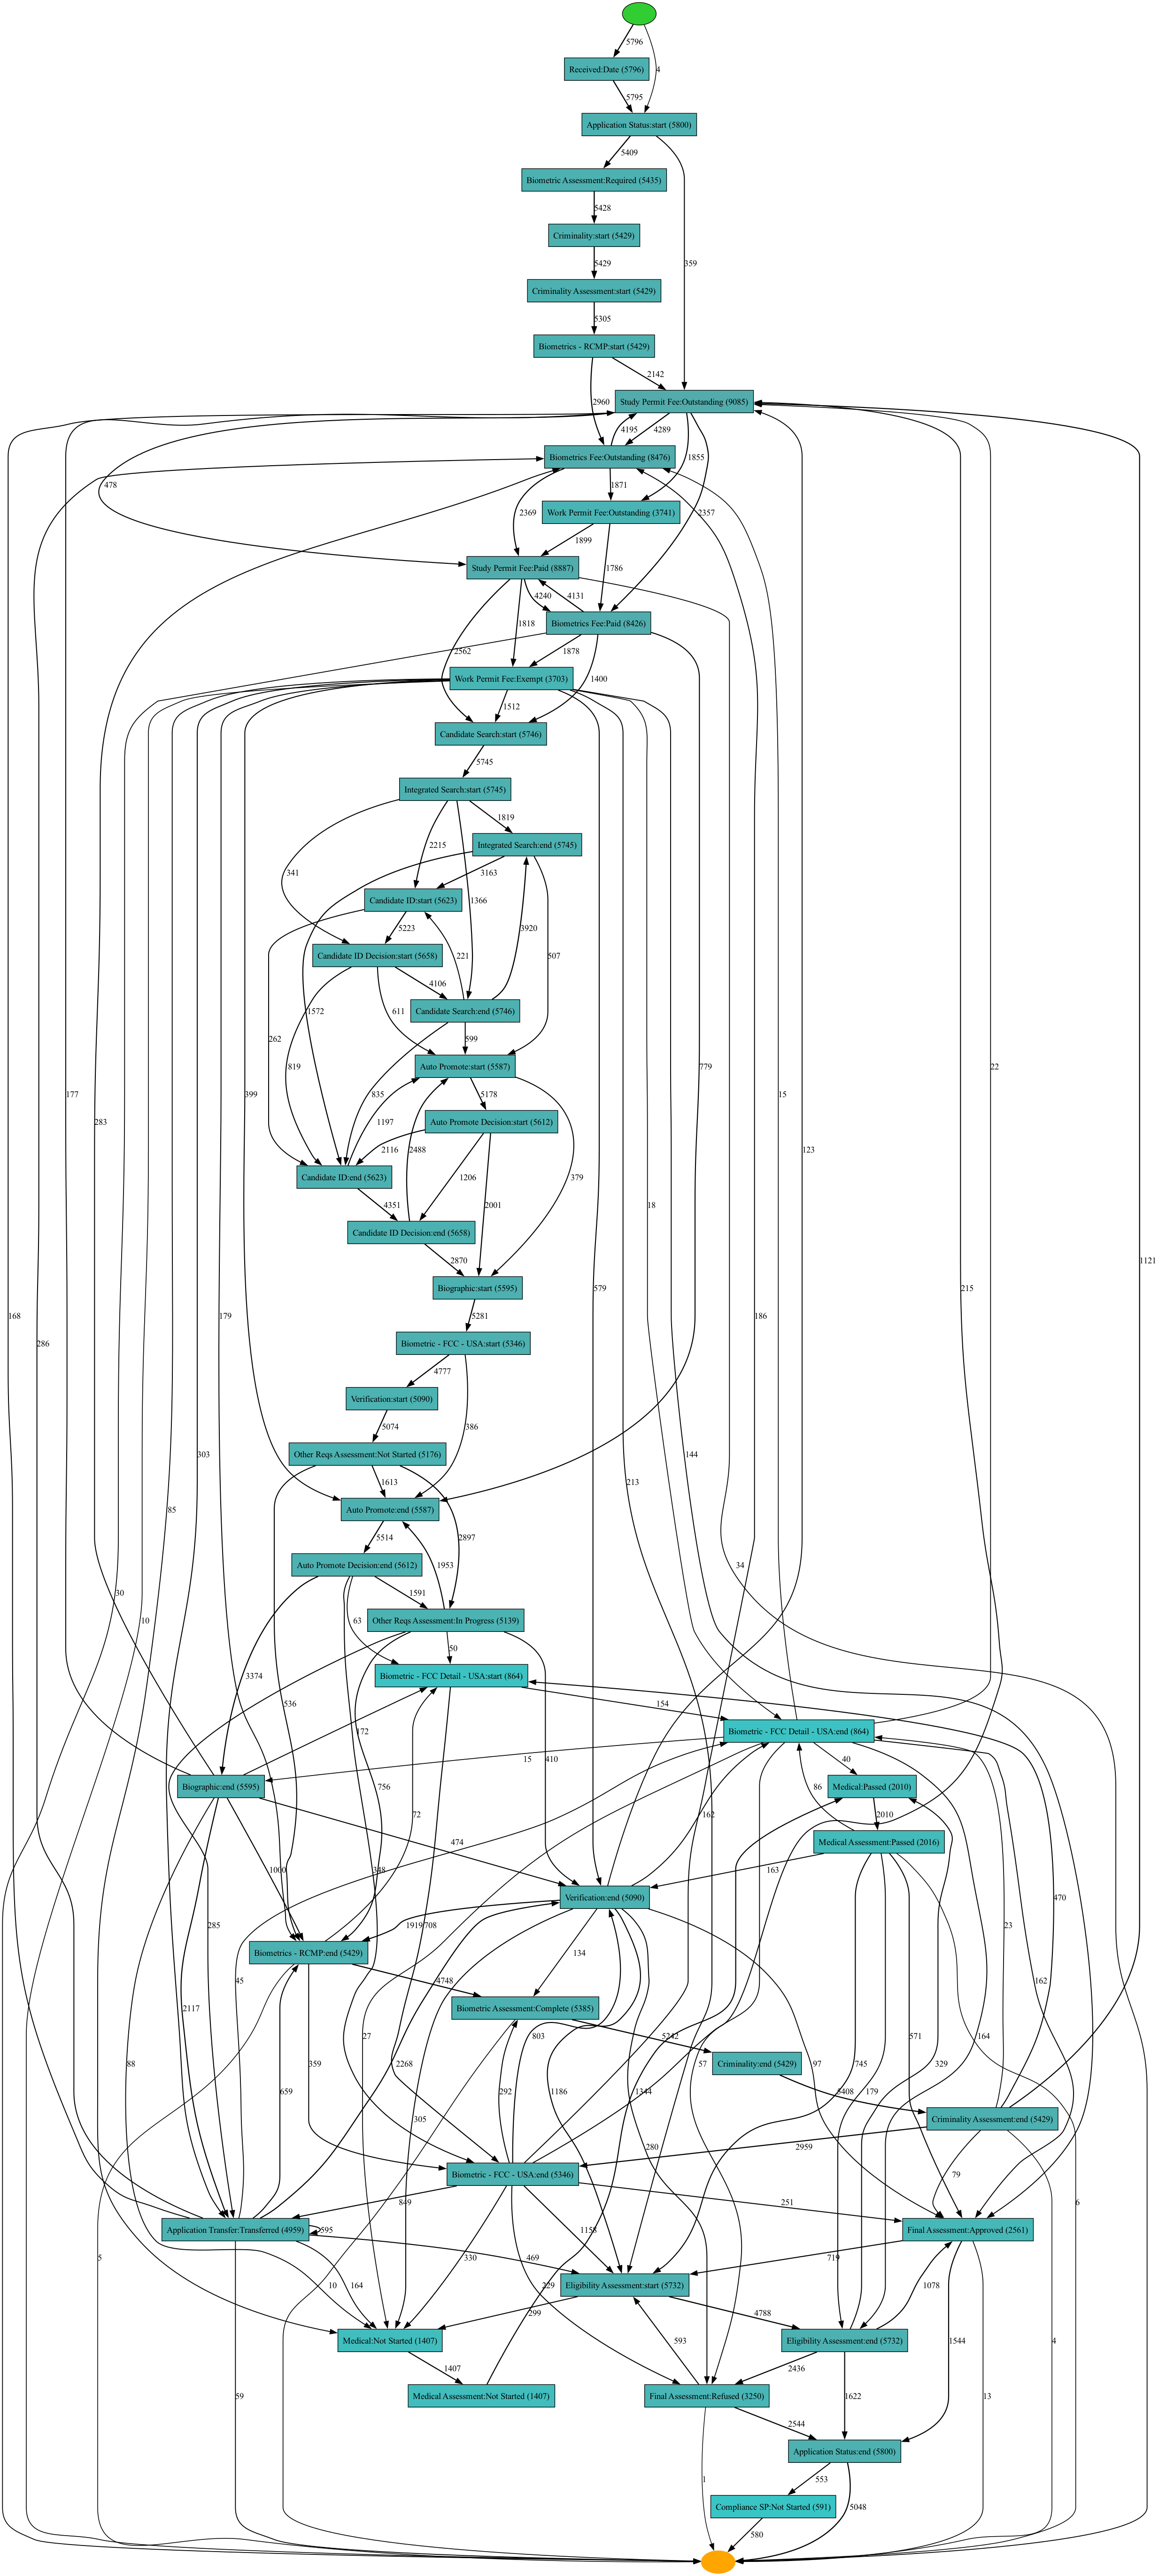

In [47]:
from mine_utils import mine_heur

mine_heur(abstract_log4)